In [70]:
from statsforecast import StatsForecast
from statsforecast.models import (Naive, SeasonalNaive, AutoARIMA, AutoETS, AutoTheta, AutoCES)
from datasetsforecast.losses import mse, mae, mape, smape
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

In [71]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2015-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df['y'] = np.log(Y_df['y'].div(Y_df.groupby('unique_id')['y'].shift(1)))
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df

[*********************100%%**********************]  8 of 8 completed


,unique_id,ds,y
0,AAPL,2015-02-01,0.092077
1,AAPL,2015-03-01,-0.027935
2,AAPL,2015-04-01,0.005770
3,AAPL,2015-05-01,0.040173
4,AAPL,2015-06-01,-0.033770
...,...,...,...
907,NVDA,2024-03-01,0.132893
908,NVDA,2024-04-01,-0.044700
909,NVDA,2024-05-01,0.238128
910,NVDA,2024-06-01,0.119427


In [72]:
Y_df['Z-Score'] = Y_df.groupby('unique_id')['y'].transform(lambda x: zscore(x, nan_policy='omit'))
data = Y_df[Y_df['unique_id'] == 'NVDA']
data

,unique_id,ds,y,Z-Score
798,NVDA,2015-02-01,0.138856,0.677143
799,NVDA,2015-03-01,-0.048739,-0.732458
800,NVDA,2015-04-01,0.058909,0.076418
801,NVDA,2015-05-01,-0.003158,-0.389957
802,NVDA,2015-06-01,-0.091099,-1.050750
...,...,...,...,...
907,NVDA,2024-03-01,0.132893,0.632338
908,NVDA,2024-04-01,-0.044700,-0.702103
909,NVDA,2024-05-01,0.238128,1.423079
910,NVDA,2024-06-01,0.119427,0.531152


In [73]:
def detect_and_correct_anomalies(group):
    group = group.sort_values(by='ds', ascending=True).reset_index(drop=True)
    group['Z-Score'] = abs(zscore(group['y']))

    # Detectar y corregir anomalías
    group.loc[group['Z-Score'] > 2, 'y'] = np.nan
    group['y'] = group['y'].interpolate(method='linear')

    # Eliminar la columna Z-Score
    group = group.drop(columns=['Z-Score'])

    return group

ts_not_anom= Y_df.groupby('unique_id').apply(detect_and_correct_anomalies).reset_index(drop=True)
ts_not_anom

,unique_id,ds,y
0,AAPL,2015-02-01,0.092077
1,AAPL,2015-03-01,-0.027935
2,AAPL,2015-04-01,0.005770
3,AAPL,2015-05-01,0.040173
4,AAPL,2015-06-01,-0.033770
...,...,...,...
907,NVDA,2024-03-01,0.132893
908,NVDA,2024-04-01,-0.044700
909,NVDA,2024-05-01,0.238128
910,NVDA,2024-06-01,0.119427


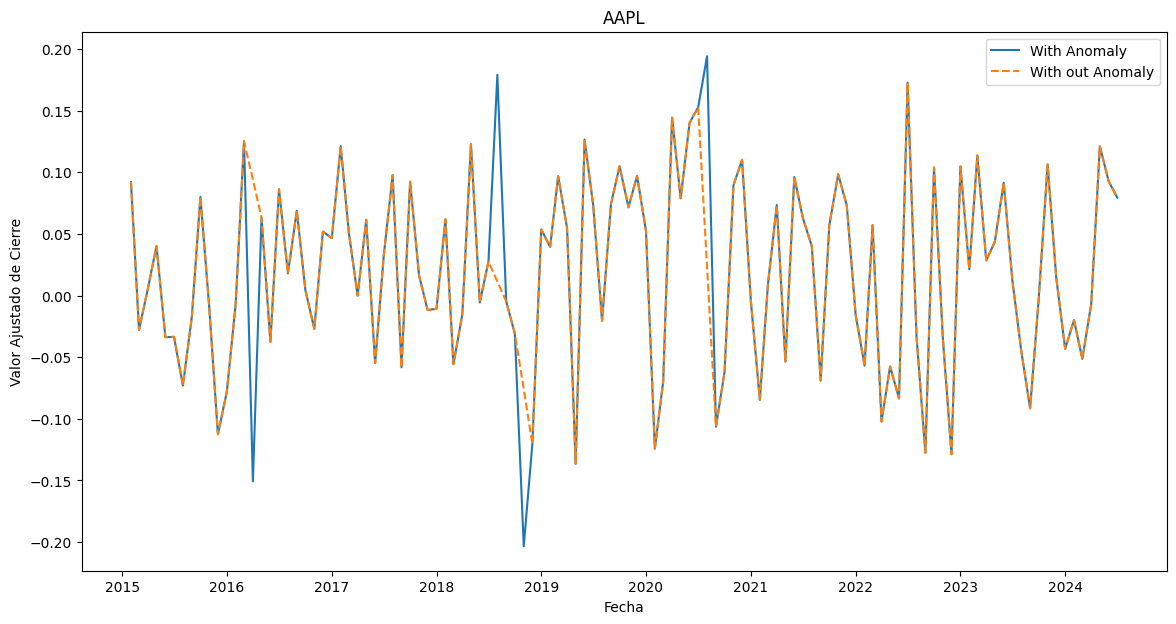

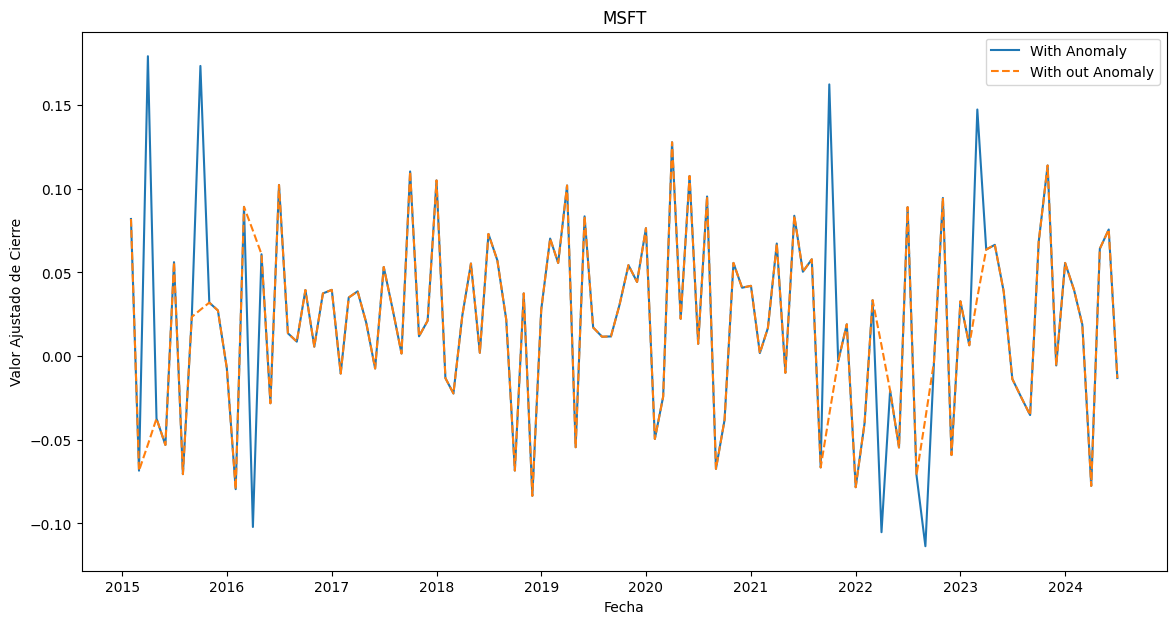

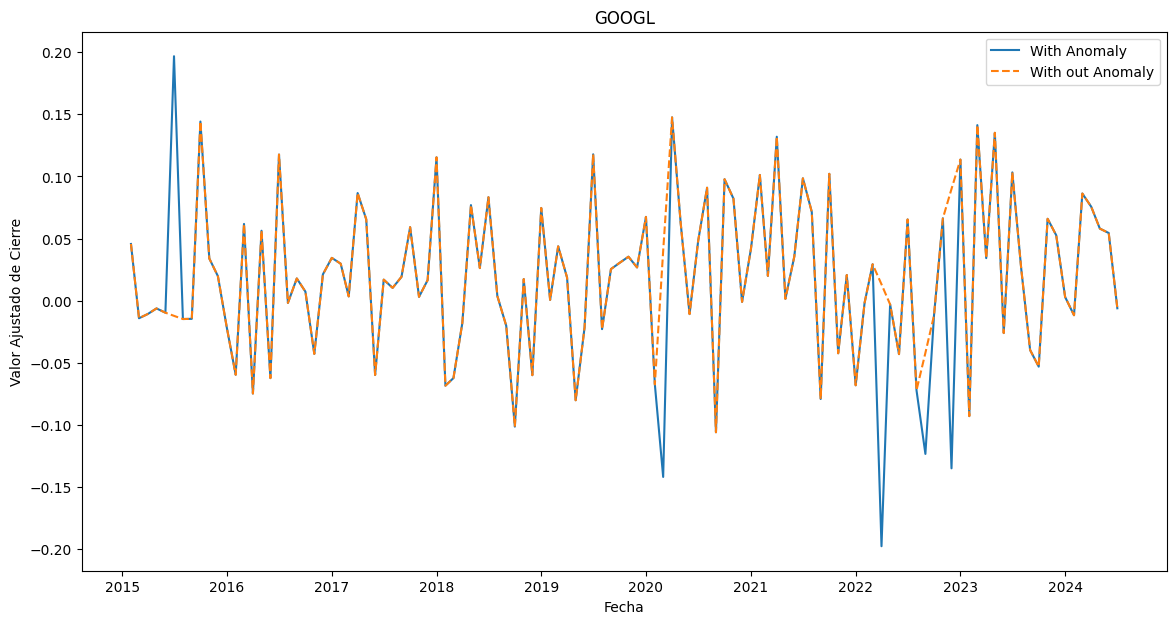

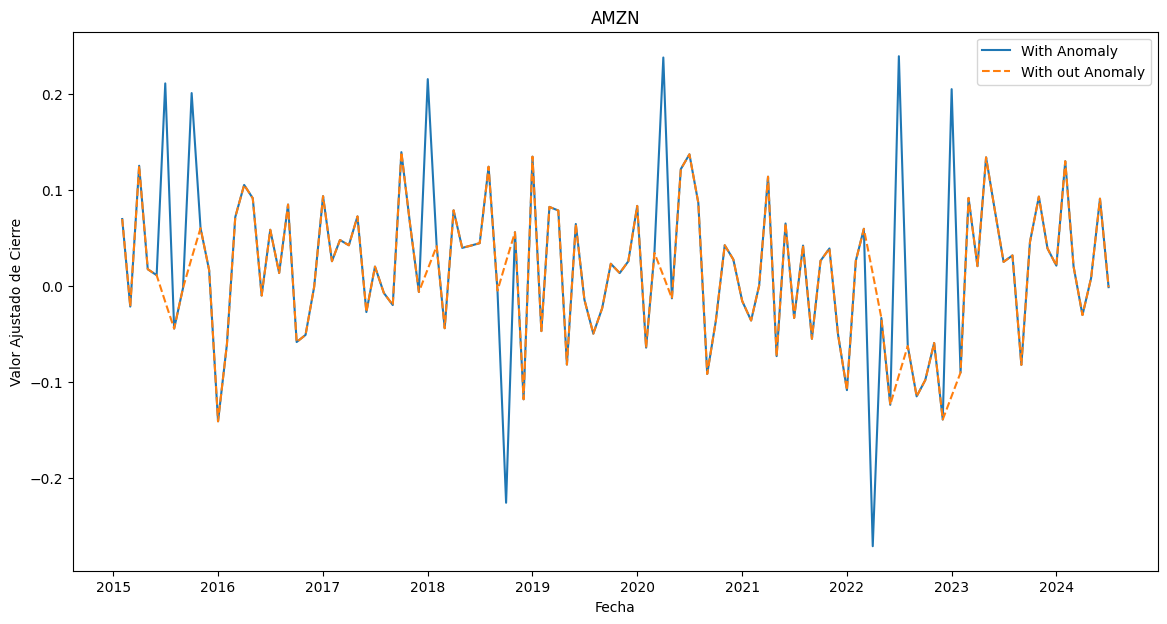

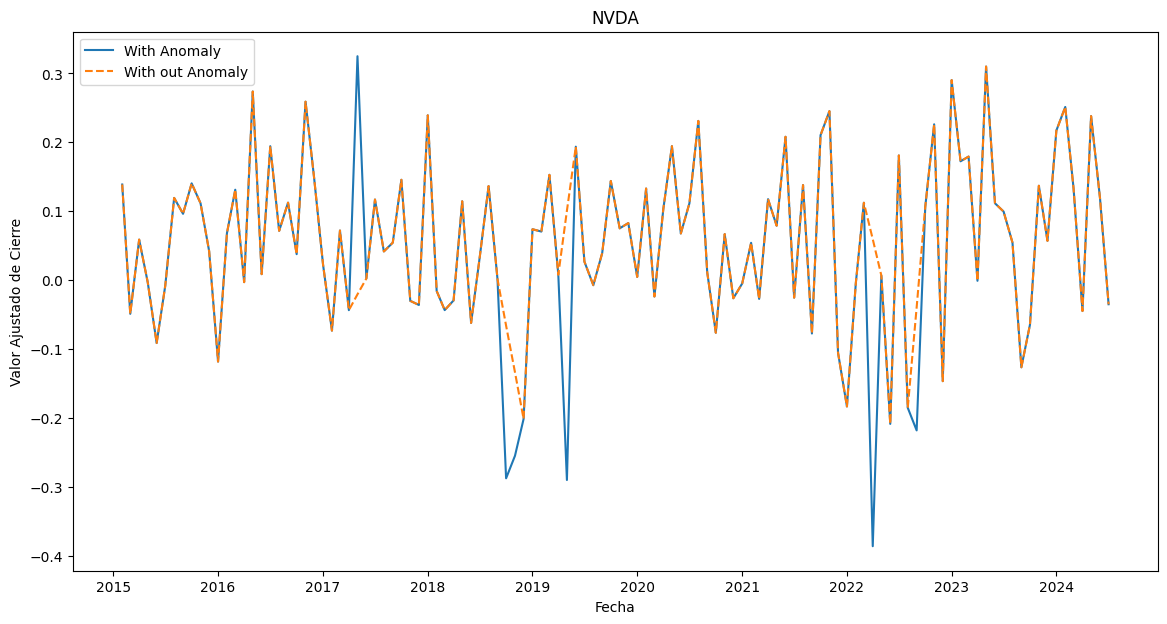

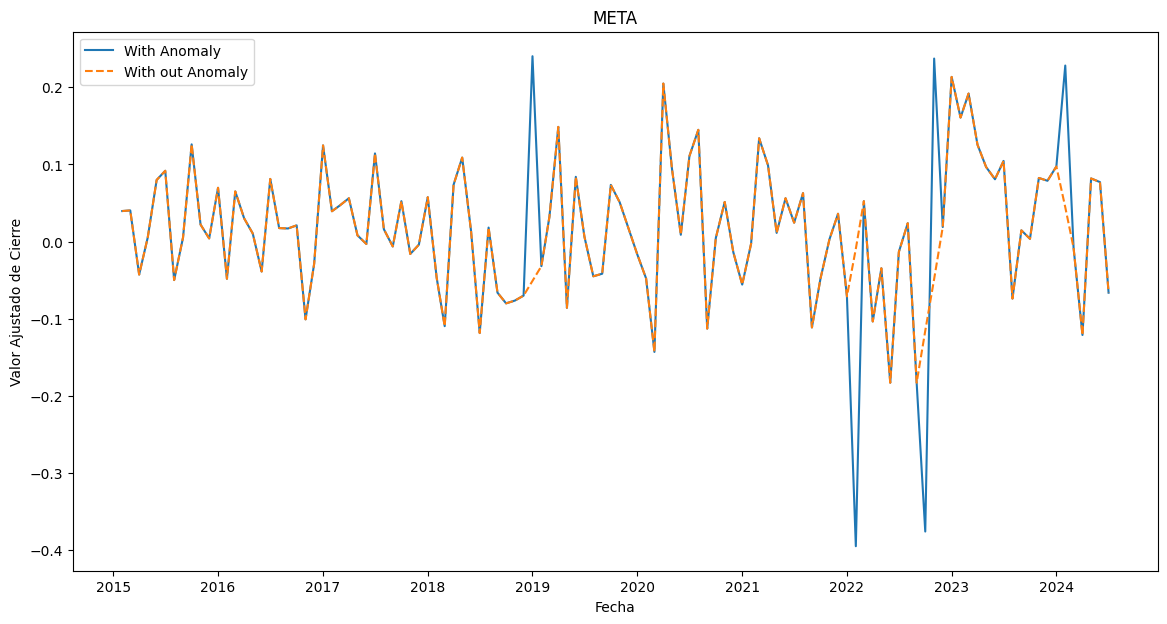

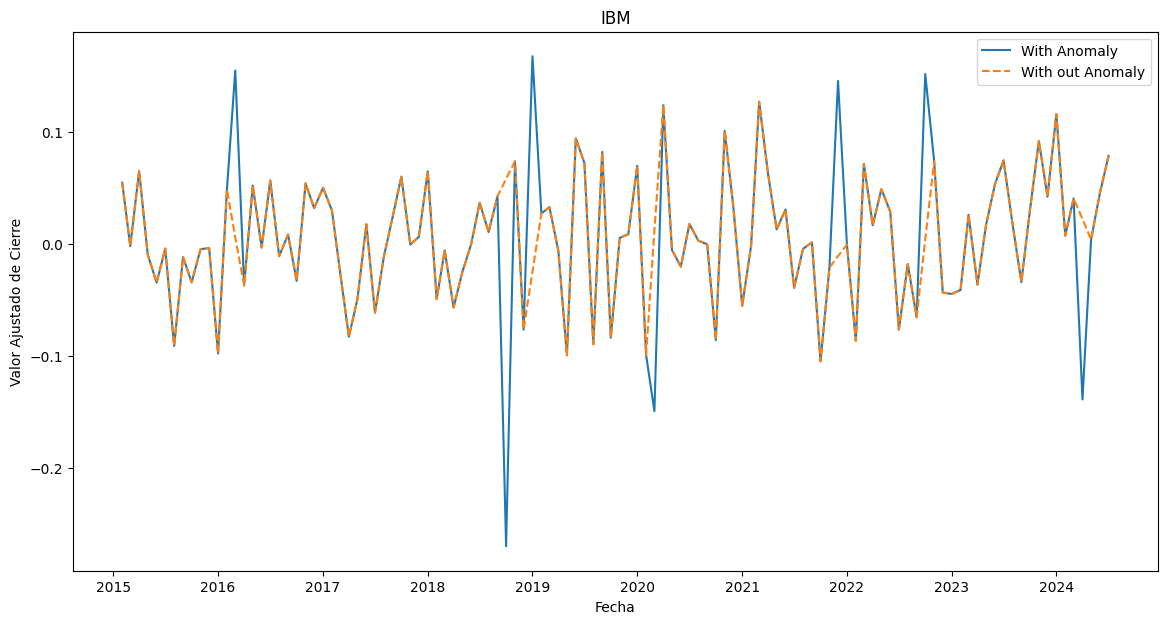

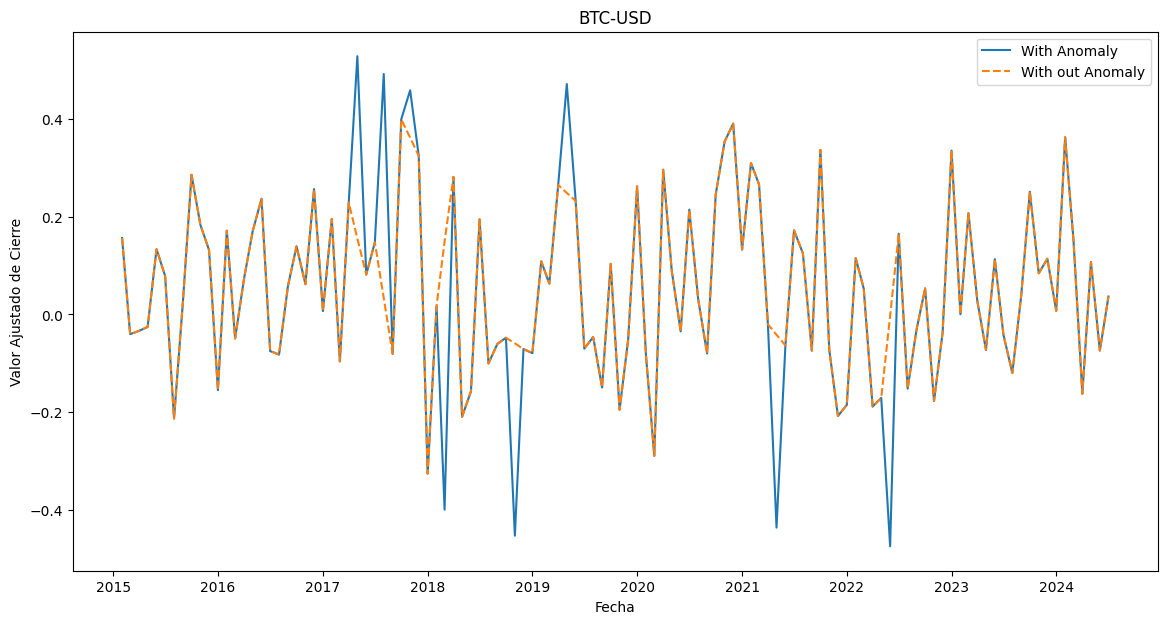

In [74]:
# Agrupar los datos originales y corregidos por 'unique_id' (ticker)
ts_original = Y_df.groupby('unique_id')
ts_corrected = ts_not_anom.groupby('unique_id')

# Iterar sobre cada ticker y graficar
for ticker in tickers:
    plt.figure(figsize=(14, 7))

    # Datos originales
    original_data = ts_original.get_group(ticker)
    corrected_data = ts_corrected.get_group(ticker)

    plt.plot(original_data['ds'], original_data['y'], label='With Anomaly')
    plt.plot(corrected_data['ds'], corrected_data['y'], label='With out Anomaly', linestyle='--')

    plt.title(f'{ticker}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor Ajustado de Cierre')
    plt.legend()
    plt.show()


In [75]:
# Contar NaNs por unique_id
nan_counts = ts_not_anom.groupby('unique_id')['y'].apply(lambda x: x.isna().sum())
print(nan_counts)

unique_id
AAPL       0
AMZN       0
BTC-USD    0
GOOGL      0
IBM        0
META       0
MSFT       0
NVDA       0
Name: y, dtype: int64


In [76]:
season_length = 12 # Define season length as 12 months for monthly data
horizon = 1 # Forecast horizon is set to 1 month

# Define a list of models for forecasting
models = [
    Naive(),
    SeasonalNaive(season_length=season_length),
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='M',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [77]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=ts_not_anom, h=horizon) # forecast data
Y_hat_df.head() 

,ds,Naive,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,,,
AAPL,2024-07-31,0.079465,-0.044658,0.014301,0.019324,0.026247,0.021533
AMZN,2024-07-31,-0.001191,0.031877,0.013141,0.015009,0.020363,0.011335
BTC-USD,2024-07-31,0.036702,-0.119742,0.012270,0.055659,0.049439,-0.055282
GOOGL,2024-07-31,-0.006181,0.025662,0.005279,0.020996,0.033360,0.029427
IBM,2024-07-31,0.078694,0.018213,0.002647,0.005877,0.032458,-0.022609


In [78]:
cv_df = sf.cross_validation(df=ts_not_anom, h=horizon, n_windows=3, step_size=horizon, level=[95])
cv_df.head()

,ds,cutoff,y,Naive,Naive-lo-95,Naive-hi-95,SeasonalNaive,SeasonalNaive-lo-95,SeasonalNaive-hi-95,AutoARIMA,...,AutoARIMA-hi-95,AutoETS,AutoETS-lo-95,AutoETS-hi-95,AutoTheta,AutoTheta-lo-95,AutoTheta-hi-95,CES,CES-lo-95,CES-hi-95
unique_id,,,,,,,,,,,,,,,,,,,,,
AAPL,2024-05-01,2024-04-01,0.121059,-0.006729,-0.200564,0.187106,0.043647,-0.160697,0.247991,0.003583,...,0.147374,0.017220,-0.128055,0.162495,0.000219,-0.124431,0.148674,0.042943,-0.157410,0.236762
AAPL,2024-06-01,2024-05-01,0.092614,0.121059,-0.073360,0.315478,0.091525,-0.112361,0.295410,0.020022,...,0.164827,0.018033,-0.127878,0.163943,0.012303,-0.113284,0.161875,0.076532,-0.120409,0.270407
AAPL,2024-07-01,2024-06-01,0.079465,0.092614,-0.101006,0.286235,0.012704,-0.190169,0.215578,0.002467,...,0.147237,0.018721,-0.127185,0.164627,0.020334,-0.105337,0.170006,0.094322,-0.098860,0.286799
AMZN,2024-05-01,2024-04-01,0.008195,-0.030280,-0.201146,0.140587,0.134077,-0.051677,0.319830,-0.005804,...,0.126494,0.005211,-0.129636,0.140059,0.015784,-0.095164,0.147920,0.008627,-0.177314,0.180786
AMZN,2024-06-01,2024-05-01,0.091004,0.008195,-0.162051,0.178440,0.077986,-0.108475,0.264448,0.001564,...,0.133290,0.005305,-0.128918,0.139528,0.015025,-0.095411,0.146551,0.024993,-0.153813,0.202475


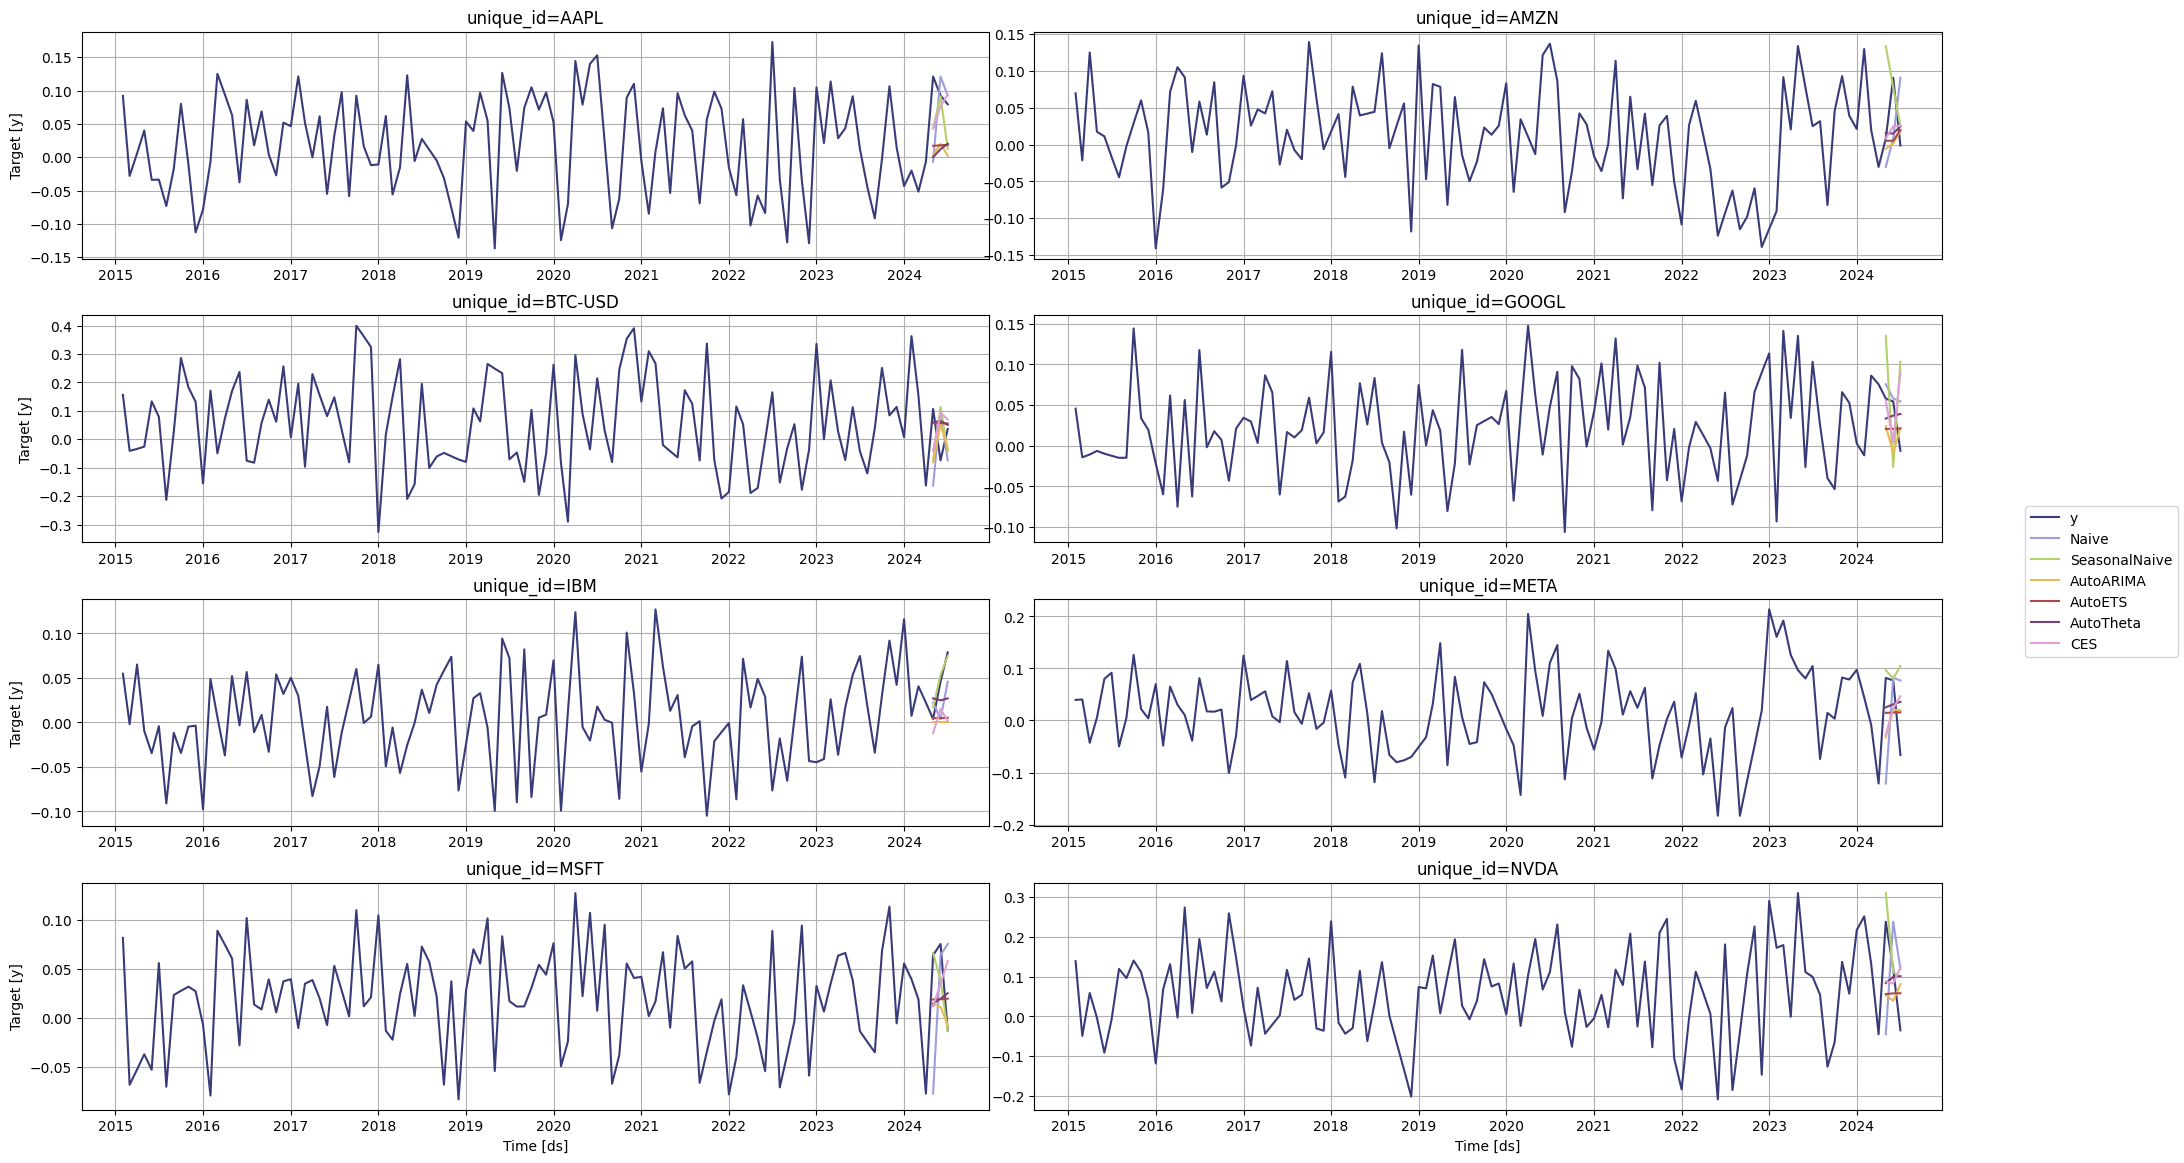

In [79]:
StatsForecast.plot(ts_not_anom, cv_df.drop(['cutoff', 'y'], axis=1))

In [80]:
cv_df = pd.DataFrame(cv_df)
cv_df.index.name = 'unique_id'

# Transformar índice en columna
cv_df.reset_index(inplace=True)

In [81]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [82]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [83]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})

In [88]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, mape, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)
evaluation_df

,unique_id,cutoff,metric,Naive,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta,CES
0,AAPL,2024-05-01,mse,0.000809,0.000001,0.00527,0.005562,0.00645,0.000259
1,AAPL,2024-05-01,mae,0.028444,0.00109,0.072592,0.074582,0.080311,0.016082
2,AAPL,2024-05-01,mape,30.712818,1.176687,78.380791,80.529472,86.715912,17.365011
3,AAPL,2024-05-01,smape,26.624287,1.183651,128.895432,134.810608,153.09462,19.016085
4,BTC-USD,2024-04-01,mse,0.072664,0.032285,0.0348,0.002538,0.002217,0.021505
...,...,...,...,...,...,...,...,...,...
15,META,2024-06-01,smape,200.0,200.0,200.0,200.0,200.0,200.0
16,NVDA,2024-06-01,mse,0.023799,0.018084,0.013446,0.008688,0.018547,0.024755
17,NVDA,2024-06-01,mae,0.154268,0.134476,0.115957,0.093208,0.136188,0.157336
18,NVDA,2024-06-01,mape,442.770874,385.963715,332.812744,267.520325,390.878357,451.577057


In [89]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

Naive  SeasonalNaive   AutoARIMA     AutoETS  \
cutoff     metric                                                       
2024-04-01 mae        0.137406       0.070305    0.088023    0.061239   
           mape     239.397934     286.364929   111.95713   60.808567   
           mse        0.029047       0.008205     0.01242      0.0068   
           smape    170.832382      90.377441  165.616302    93.06514   
2024-05-01 mae        0.059089       0.042236    0.074906     0.06819   
           mape       73.15213      61.649574   98.766304   88.643936   
           mse        0.007059       0.005394    0.006159    0.005457   
           smape     82.162224      63.540146  160.999481  135.765244   
2024-06-01 mae           0.087       0.073874    0.060282    0.051267   
           mape    1302.316528     616.614929  379.360474  385.732697   
           mse        0.009741       0.008824    0.004893    0.003394   
           smape    158.519623     144.284821  181.086456  167.562592   

                    AutoTheta         CES  
cutoff     metric                          
2024-04-01 mae       0.060437     0.06937  
           mape    135.355591  111.856117  
           mse       0.005931    0.008123  
           smape   106.161461  116.675026  
2024-05-01 mae       0.056919    0.057659  
           mape      73.22596   78.681557  
           mse       0.004732     0.00524  
           smape   101.825638  102.697861  
2024-06-01 mae       0.059137    0.073827  
           mape     493.06192  650.664978  
           mse       0.004945      0.0075  
           smape   156.060577  158.864319

<Axes: xlabel='error', ylabel='model'>

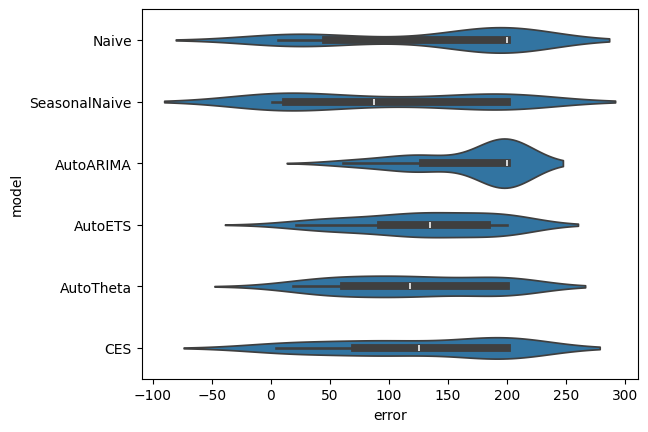

In [90]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

<Axes: xlabel='n', ylabel='best_model'>

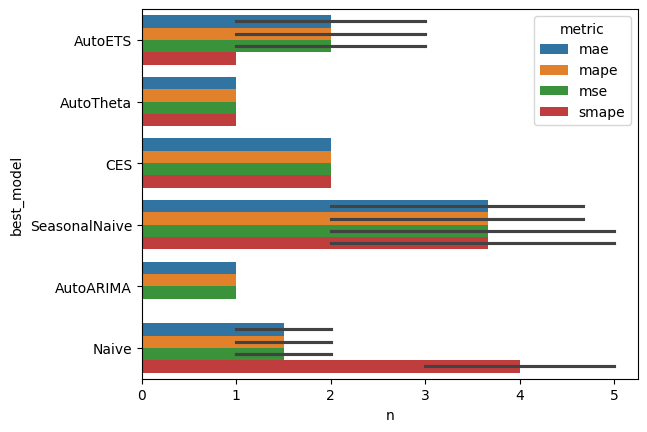

In [91]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')